<a href="https://colab.research.google.com/github/nedokormysh/GB_ML_business/blob/lesson2/ML_business_hw_2_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
!pip install razdel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [148]:
!pip install pymorphy2 -q

In [149]:
!pip install pyLDAvis -q

In [150]:
import pandas as pd

In [151]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2023-01-30 09:03:32--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 74.125.23.138, 74.125.23.113, 74.125.23.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.23.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2n2harsoegflmssl3fc8hv4tsvab36et/1675069350000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=a2be2b7a-56e0-4a7b-825c-e6b71d19b5a5 [following]
--2023-01-30 09:03:33--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2n2harsoegflmssl3fc8hv4tsvab36et/1675069350000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download&uuid=a2be2b7a-56e0-4a7b-825c-e6b71d19b5a5
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 108.177.125.132, 240

Наши новости

In [152]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [153]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


# 1. 

Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

# 2. 

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

## Для среднего (повтор занятия)

### Получаем векторные представления новостей

In [154]:
from gensim.corpora.dictionary import Dictionary
#предобработка текстов
import re
import numpy as np

from razdel import tokenize # https://github.com/natasha/razdel
import pymorphy2

In [155]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [156]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [157]:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt -q

In [158]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [159]:
# stopword_ru[-150]

In [160]:
# morph = pymorphy2.MorphAnalyzer()

In [161]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [162]:
# news.iloc[0, 1]

In [163]:
# news.iloc[2, 1]

In [164]:
# %%time

In [165]:
%%time
from tqdm import tqdm
tqdm.pandas()


# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████| 27000/27000 [01:01<00:00, 442.49it/s] 

CPU times: user 43.6 s, sys: 641 ms, total: 44.2 s
Wall time: 1min 1s


In [166]:
# news['title'].iloc[:10]

In [167]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 16s, sys: 1.01 s, total: 4min 17s
Wall time: 4min 23s


А теперь в 3 строчки обучим нашу модель

In [168]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [169]:
N_topic = 20

In [170]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=10)

CPU times: user 5min 57s, sys: 2min 59s, total: 8min 56s
Wall time: 6min 18s


In [171]:
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [172]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.43822336),
 (3, 0.070347525),
 (4, 0.11953406),
 (6, 0.028248405),
 (7, 0.055202268),
 (10, 0.21308033),
 (13, 0.059114046)]

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [173]:
x = lda.show_topics(num_topics=N_topic, num_words=7, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: учёный ракета журнал опубликовать мозг луна университет
topic_1: сша банк американский россия санкция российский трамп
topic_2: эксперимент памятник команда собака игра фотография физика
topic_3: украина украинский киев восток депутат россия порошенко
topic_4: исследование день всё жизнь очень научный статья
topic_5: корабль сирия сила сша удар сторона война
topic_6: млн рост цена рынок тыс руб составить
topic_7: сотрудник писать мужчина дом данные произойти задержать
topic_8: газ нефть газпром поток северный ввп европа
topic_9: россия российский правительство регион путин глава рф
topic_10: москва станция русский мероприятие площадь день московский
topic_11: вода тело взрыв помощь клетка пострадать заболевание
topic_12: земля исследователь животное район px высота территория
topic_13: население смерть пенсия турция инвестиция турецкий торговый
topic_14: военный армия российский боевой оборона войско россия
topic_15: ребёнок министерство школа квартира семья область образовани

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [174]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [175]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.35358545, 0.06349297, 0.12976176, 0.0100692 ,
       0.        , 0.        , 0.06226956, 0.        , 0.18324503,
       0.        , 0.        , 0.        , 0.        , 0.07976446,
       0.1125484 , 0.        , 0.        , 0.        , 0.        ])

In [176]:
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.353585,0.063493,0.129760,0.010069,0.0,0.000000,0.062270,0.0,...,0.000000,0.000000,0.0,0.000000,0.079765,0.112553,0.0,0.000000,0.0,0.0
1,4896,0.0,0.000000,0.447087,0.000000,0.062617,0.0,0.000000,0.147599,0.0,...,0.000000,0.323184,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,4897,0.0,0.000000,0.438226,0.070341,0.119536,0.0,0.028248,0.055207,0.0,...,0.213079,0.000000,0.0,0.059113,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,4898,0.0,0.000000,0.353785,0.113579,0.269306,0.0,0.000000,0.055945,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.198239,0.0,0.0
4,4899,0.0,0.000000,0.071712,0.086165,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.819150,0.0,0.000000,0.0,0.0


### Следующий шаг - векторные представления пользователей

In [177]:
users.head(5)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [178]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [179]:
doc_dict[293672]

array([0.        , 0.        , 0.        , 0.06235618, 0.        ,
       0.02639197, 0.07470074, 0.02680994, 0.        , 0.27029768,
       0.4469851 , 0.        , 0.        , 0.        , 0.0237914 ,
       0.        , 0.        , 0.05666702, 0.        , 0.        ])

In [180]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector

In [181]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.00198666, 0.14991755, 0.        , 0.02133756, 0.05634496,
       0.04638635, 0.02314252, 0.04005064, 0.0338446 , 0.14307293,
       0.01083991, 0.01635501, 0.00412017, 0.01166154, 0.13295115,
       0.07479533, 0.02270203, 0.0902392 , 0.        , 0.11094925])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [182]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.mean))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.026869,0.025642,0.057288,0.102864,0.020314,0.066200,0.045518,0.092479,0.013697,...,0.130413,0.024992,0.000000,0.052991,0.003965,0.026960,0.008672,0.021010,0.053682,0.075227
1,u108690,0.000000,0.124621,0.000000,0.117952,0.075481,0.037584,0.029546,0.107400,0.004805,...,0.020374,0.022257,0.006316,0.032691,0.019646,0.076147,0.009148,0.083321,0.009506,0.070865
2,u108339,0.000000,0.062467,0.000000,0.017567,0.070643,0.027385,0.002236,0.103853,0.077968,...,0.042787,0.116692,0.010694,0.013756,0.009829,0.038305,0.048396,0.020315,0.001887,0.133175


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [183]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2023-01-30 09:16:11--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 108.177.97.138, 108.177.97.101, 108.177.97.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqe7bjh022itj3cpbd9pum7tp0pktal9/1675070100000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=f8f29a6f-122f-4824-8d17-712020cdabb8 [following]
--2023-01-30 09:16:13--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hqe7bjh022itj3cpbd9pum7tp0pktal9/1675070100000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download&uuid=f8f29a6f-122f-4824-8d17-712020cdabb8
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 108.177.125.132, 2404

In [184]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [185]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.026869,0.025642,0.057288,0.102864,0.020314,0.066200,0.045518,0.092479,0.013697,...,0.024992,0.000000,0.052991,0.003965,0.026960,0.008672,0.021010,0.053682,0.075227,0
1,u108690,0.000000,0.124621,0.000000,0.117952,0.075481,0.037584,0.029546,0.107400,0.004805,...,0.022257,0.006316,0.032691,0.019646,0.076147,0.009148,0.083321,0.009506,0.070865,1
2,u108339,0.000000,0.062467,0.000000,0.017567,0.070643,0.027385,0.002236,0.103853,0.077968,...,0.116692,0.010694,0.013756,0.009829,0.038305,0.048396,0.020315,0.001887,0.133175,1


In [186]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [187]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [188]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [189]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0020496 , 0.05601554, 0.01444551, 0.02578597, 0.07919037,
       0.10217876, 0.01187749, 0.05932728, 0.35748836, 0.04569136])

In [190]:
# создадим датафрейм для сбора всех результатов в таблицу
df_results = pd.DataFrame(columns=['model', 'threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC


### Рассчитаем Precision, Recall, F_score

In [191]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [192]:
# plt.plot( preds[:100], label = 'predict')
# plt.plot(y_test.values[:100], label = 'true')
# plt.title('ответ модели')
# plt.xlabel(' № примера')
# plt.ylabel(' выход')
# plt.legend()
# plt.grid('On')
# plt.show()

In [193]:
def draw_res(y_test, preds):
  plt.plot(preds[:100], label = 'predict')
  plt.plot(y_test.values[:100], label = 'true')
  plt.title('ответ модели')
  plt.xlabel(' № примера')
  plt.ylabel(' выход')
  plt.legend()
  plt.grid('On')
  plt.show()

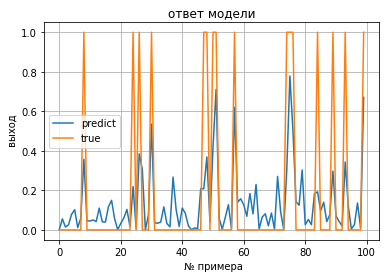

In [194]:
draw_res(y_test, preds)

In [195]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)

In [196]:
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.30846739450784083, F-Score=0.772, Precision=0.867, Recall=0.696


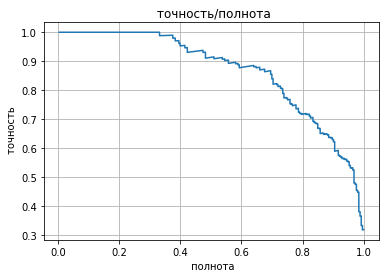

In [197]:
# n = -1
# plt.plot(recall[:n],precision[:n] )
# plt.title(' точность/полнота')
# plt.xlabel(' полнота')
# plt.ylabel(' точность')
# plt.grid('On')
# plt.show()

In [213]:
def draw_res_2(recall, precision):
  n = -1
  plt.plot(recall[:n],precision[:n] )
  plt.title(' точность/полнота')
  plt.xlabel(' полнота')
  plt.ylabel(' точность')
  plt.grid('On')
  plt.show()

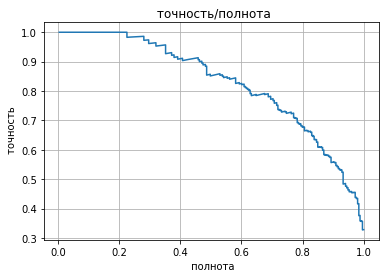

In [214]:
draw_res_2(recall, precision)

In [198]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.97402435796204

In [199]:
# df_results = df_results.append({
#     'model': 'mean',
#     'thresh': thresholds[ix],
#     'F-Score': fscore[ix],
#     'Precision': precision[ix],
#     'Recall': recall[ix],
#     'ROC AUC': roc_auc
# }, ignore_index=True)

# df_results

In [200]:
# len(df_results.index)

In [201]:
df_results.loc[len(df_results.index)] = ['mean', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.308467,0.77193,0.866995,0.695652,0.974024


# 2.

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [202]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.median))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.009350,0.042479,0.020791,0.000000,0.059186,0.028672,0.074550,0.00000,...,0.103041,0.000000,0.0,0.014517,0.0,0.000000,0.000000,0.000000,0.005528,0.030652
1,u108690,0.0,0.038804,0.000000,0.080163,0.056217,0.034748,0.006928,0.076143,0.00000,...,0.014188,0.008130,0.0,0.036916,0.0,0.050407,0.006924,0.074677,0.008411,0.037577
2,u108339,0.0,0.026772,0.000000,0.019104,0.059801,0.012386,0.000000,0.090775,0.04632,...,0.000000,0.121339,0.0,0.006861,0.0,0.043282,0.028829,0.000000,0.000000,0.116904


In [203]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.009350,0.042479,0.020791,0.000000,0.059186,0.028672,0.074550,0.00000,...,0.000000,0.0,0.014517,0.0,0.000000,0.000000,0.000000,0.005528,0.030652,0
1,u108690,0.0,0.038804,0.000000,0.080163,0.056217,0.034748,0.006928,0.076143,0.00000,...,0.008130,0.0,0.036916,0.0,0.050407,0.006924,0.074677,0.008411,0.037577,1
2,u108339,0.0,0.026772,0.000000,0.019104,0.059801,0.012386,0.000000,0.090775,0.04632,...,0.121339,0.0,0.006861,0.0,0.043282,0.028829,0.000000,0.000000,0.116904,1


In [204]:
# # разделим данные на train/test
# X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
#                                                     X['churn'], random_state=0)
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [205]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [206]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.00234736, 0.07129312, 0.00900379, 0.03300591, 0.0772019 ,
       0.07572786, 0.01568594, 0.05136166, 0.33516951, 0.09387043])

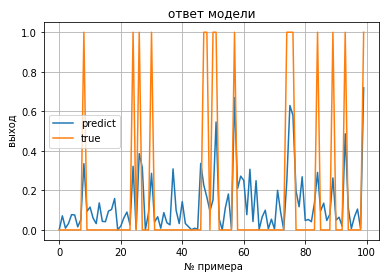

In [207]:
draw_res(y_test, preds)

In [208]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.2622112213701254, F-Score=0.747, Precision=0.725, Recall=0.771


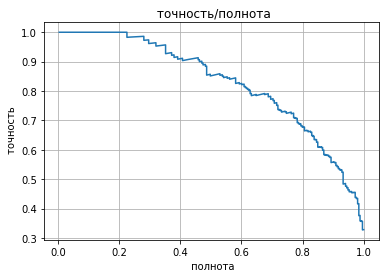

In [209]:
# n = -1
# plt.plot(recall[:n],precision[:n] )
# plt.title(' точность/полнота')
# plt.xlabel(' полнота')
# plt.ylabel(' точность')
# plt.grid('On')
# plt.show()

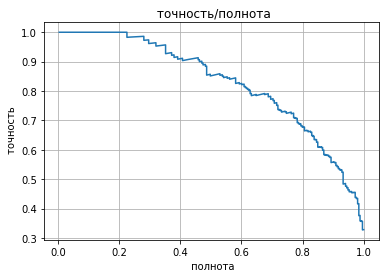

In [216]:
draw_res_2(recall, precision)

In [210]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9668658411596617

In [211]:
df_results.loc[len(df_results.index)] = ['median', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.308467,0.771930,0.866995,0.695652,0.974024
1,median,0.262211,0.747126,0.724907,0.770751,0.966866


# 3.

Повторить п.2, но используя уже не медиану, а max

In [217]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, np.max))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.122087,0.100431,0.159733,0.513243,0.068534,0.160686,0.141063,0.284304,0.082182,...,0.446985,0.149949,0.000000,0.238877,0.023791,0.123202,0.029696,0.069395,0.211948,0.273808
1,u108690,0.000000,0.436235,0.000000,0.279871,0.202260,0.091227,0.114206,0.297379,0.018504,...,0.075753,0.071476,0.037899,0.057544,0.082043,0.290087,0.023667,0.154308,0.022084,0.233156
2,u108339,0.000000,0.200745,0.000000,0.038207,0.169327,0.090139,0.013416,0.225004,0.232953,...,0.142795,0.223431,0.064166,0.040462,0.058971,0.066088,0.167510,0.093775,0.011320,0.326959


In [218]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.122087,0.100431,0.159733,0.513243,0.068534,0.160686,0.141063,0.284304,0.082182,...,0.149949,0.000000,0.238877,0.023791,0.123202,0.029696,0.069395,0.211948,0.273808,0
1,u108690,0.000000,0.436235,0.000000,0.279871,0.202260,0.091227,0.114206,0.297379,0.018504,...,0.071476,0.037899,0.057544,0.082043,0.290087,0.023667,0.154308,0.022084,0.233156,1
2,u108339,0.000000,0.200745,0.000000,0.038207,0.169327,0.090139,0.013416,0.225004,0.232953,...,0.223431,0.064166,0.040462,0.058971,0.066088,0.167510,0.093775,0.011320,0.326959,1


In [219]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=42, test_size=0.25)

In [220]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [221]:
# наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([3.05692426e-04, 5.75207057e-03, 2.94638716e-02, 3.36685423e-03,
       5.39916987e-02, 7.74963477e-02, 9.27862566e-03, 5.41669636e-02,
       4.33534462e-01, 1.06661865e-02])

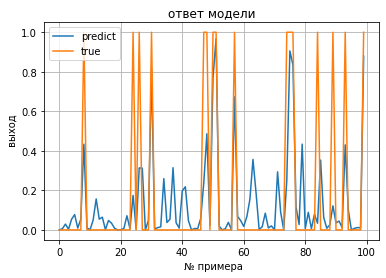

In [222]:
draw_res(y_test, preds)

In [223]:
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3768297344899103, F-Score=0.764, Precision=0.826, Recall=0.711


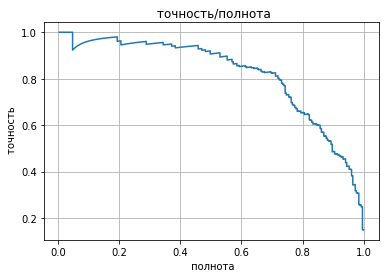

In [224]:
draw_res_2(recall, precision)

In [225]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9585760796034308

In [226]:
df_results.loc[len(df_results.index)] = ['max', thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc]
df_results

,model,threshold,F-Score,Precision,Recall,ROC AUC
0,mean,0.308467,0.771930,0.866995,0.695652,0.974024
1,median,0.262211,0.747126,0.724907,0.770751,0.966866
2,max,0.376830,0.764331,0.825688,0.711462,0.958576


# 4.

(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer

Будем интерпретировать индексы статей пользователей как слова. Попробуем получить взвешенную оценку насколько статья является распространённой

In [230]:
users['articles'].iloc[0]

'[293672, 293328, 293001, 293622, 293126, 1852]'

В tf_idf необходимо передавать строку, поэтому переведём в строки.

In [232]:
users['articles_'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))

# users['articles_'].iloc[0]
users['articles_'].head(3)

0    293672 293328 293001 293622 293126 1852
1            3405 1739 2972 1158 1599 322665
2            1845 2009 2356 1424 2939 323389
Name: articles_, dtype: object

In [231]:
# users['articles_']

0       293672 293328 293001 293622 293126 1852
1               3405 1739 2972 1158 1599 322665
2               1845 2009 2356 1424 2939 323389
3               5933 6186 5055 6977 5206 488389
4                707 1144 2532 2928 3133 324592
                         ...                   
7995     323918 323362 323704 323452 324291 251
7996            5532 5860 7755 7140 5182 488337
7997    322811 323898 321858 323345 323491 2193
7998            5436 6092 6891 7045 5320 487379
7999    294096 293759 294178 293544 293921 2909
Name: articles_, Length: 8000, dtype: object

Воспользуемся tf_idf

In [233]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_'])

TfidfVectorizer()

In [250]:
# user_articles_list = eval(user_articles_list)
user_articles_list

[323329, 321961, 324743, 323186, 324632, 474690]

In [ ]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    # user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.zeros((len(user_articles_list), N_topic))

    # user_vector = func(user_vector, axis=0)
    return user_vector

In [245]:
user_vector = np.ones((len(user_articles_list), N_topic))

In [238]:
# len(user_articles_list)
# len(user_vector)

48

In [251]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [247]:
# user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])

KeyError: ignored

In [246]:
# user_vector

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1.

# 5.

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [ ]:
metrics_df = pd.DataFrame(columns=['model', 'threshold', 'F-Score', 'Precision', 'Recall', 'ROC AUC'])
# metrics_df

# 6.